# Student Admission with Keras/TensorFlow

Comment: part of the NLP program is to practice with a Vanilla Neural Network. All easy, if there wasn't the visualization 😫

In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:

- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

In [1]:
import pandas as pd
import numpy as np

In [37]:
# fix seed
seed = 12
np.random.seed(seed)

In [4]:
data = pd.read_csv("student_data.csv")
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


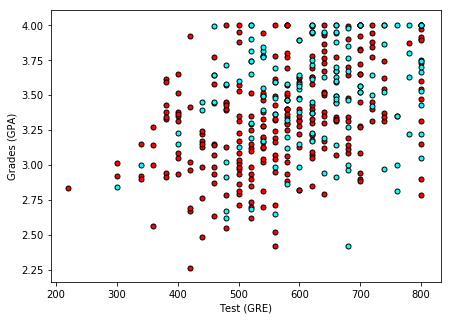

In [20]:
# Importing matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5 # adjust figure size

#Function to help us plot 😩
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

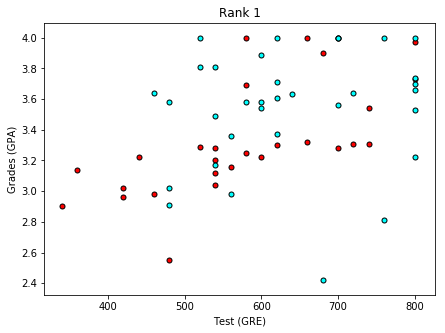

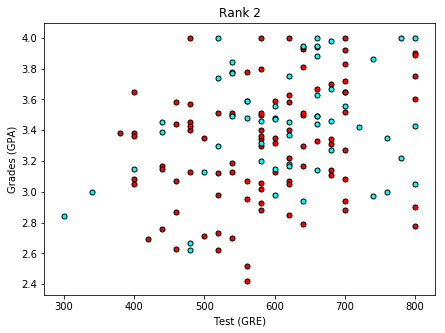

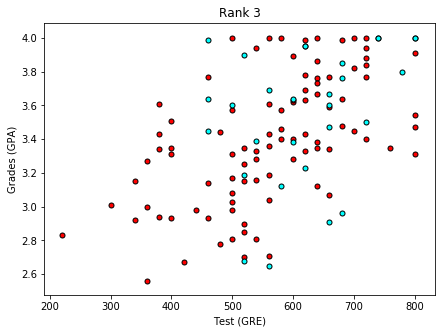

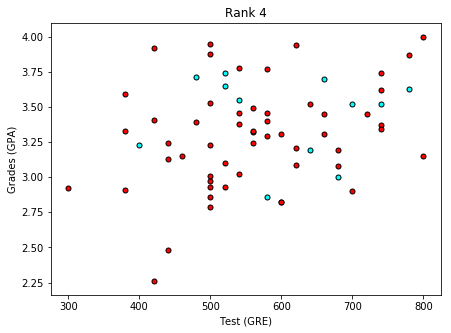

In [21]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
plot_points(data_rank2)
plt.title("Rank 2")
plt.show()
plot_points(data_rank3)
plt.title("Rank 3")
plt.show()
plot_points(data_rank4)
plt.title("Rank 4")
plt.show()

### One-hot encoding the rank
For this, we'll use the get_dummies function in pandas.

In [26]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drope the previous rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of the data
one_hot_data[:5]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [25]:
# Copying our data
processed_data = one_hot_data[:]

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:5]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.225625,0,0,1,0
1,1,0.825,0.229375,0,0,1,0
2,1,1.000,0.250000,1,0,0,0
3,1,0.800,0.199375,0,0,0,1
4,0,0.650,0.183125,0,0,0,1


### Splitting the data into Training and Testing
In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [27]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:6])
print(test_data[:6])

Number of training samples is 360
Number of testing samples is 40
     admit    gre      gpa  rank_1  rank_2  rank_3  rank_4
61       0  0.700  0.20750       0       0       0       1
220      0  0.675  0.20500       0       0       1       0
123      0  0.625  0.18625       0       0       1       0
383      0  0.825  0.25000       1       0       0       0
211      0  0.725  0.18875       0       1       0       0
265      0  0.475  0.20875       0       0       1       0
    admit    gre       gpa  rank_1  rank_2  rank_3  rank_4
11      0  0.550  0.201250       1       0       0       0
22      0  0.750  0.176250       0       0       0       1
36      0  0.725  0.203125       1       0       0       0
47      0  0.625  0.185625       0       0       0       1
48      0  0.550  0.155000       0       0       0       1
49      0  0.500  0.209375       0       0       1       0


## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`.

In [30]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(train_data.drop('admit', axis=1))
targets = np.array(keras.utils.to_categorical(train_data['admit'], 2))
features_test = np.array(test_data.drop('admit', axis=1))
targets_test = np.array(keras.utils.to_categorical(test_data['admit'], 2))

print(features[:6])
print(targets[:6])

[[0.7     0.2075  0.      0.      0.      1.     ]
 [0.675   0.205   0.      0.      1.      0.     ]
 [0.625   0.18625 0.      0.      1.      0.     ]
 [0.825   0.25    1.      0.      0.      0.     ]
 [0.725   0.18875 0.      1.      0.      0.     ]
 [0.475   0.20875 0.      0.      1.      0.     ]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## Defining the model architecture
Here's where we use Keras to build our neural network.

In [36]:
# Imports
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(6,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='sigmoid'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [33]:
# Training the model
model.fit(features, targets, epochs=200, batch_size=100, verbose=0)

### Scoring the Model

In [34]:
# Evaluating the model on the training and testing set
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

40/40 [==============================] - 0s 777us/step

 Testing Accuracy: 0.725


In [35]:
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

40/40 [==============================] - 0s 74us/step

 Testing Accuracy: 0.725
